# Cross-Validation of `lm` model

Make a cross-validation with a "k-fold" using natural years

In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(openair))

suppressMessages(library(caret))

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

## Main Variables

In [4]:
sites.lv <- c("es0118a", "es1438a") # Big cities (Madrid and Barcelona)",
sites.lv <- c(sites.lv, "es1580a", "es1340a") # small cities (Santander and Huelva)
variables.lv <- c("no2", "no", "o3", "pm10", "pm2.5")#, "no")

## DataFrame Creation

In [5]:
# Create dataSet
load("data/data_AQ.rda")
load("data/meteorology.rda")

aq <- data_AQ[data_AQ$site %in% sites.lv, ] %>%
            filter(variable %in% variables.lv) %>%
            timeAverage(avg.time = "day", type=c("site", "variable"))
aq$date <- as_date(aq$date)

mto <- data_Mto[data_Mto$site %in% sites.lv, ]

df <- merge(aq, mto,
              by = c("date", "site"), all.x=T) %>%
        drop_na() %>%
        mutate_if(is.factor, as.character) %>%
        select(-date_end, -process, -summary, -validity)

rm(data_AQ)
rm(data_Mto)

In [6]:
ds.data <- df

```R
ds.data <- cbind(df[, 1:3],
                 apply(df[, -1:-3], 2, function(cl) {
                    dcomp <- decompose(ts(cl, frequency = 365))

                    cl - dcomp$seasonal
                })) %>% data.frame()
```

In [7]:
to.predict <- ds.data[ds.data$date > ymd("2020-01-01"),]
data.df <- ds.data[ds.data$date < ymd("2020-01-01"),] 

```R
pre.data <- preProcess(ds.data[, -c(1:3)],
                                 method=c("range"))
ds.data[, -c(1:3)] <- predict(pre.data, ds.data[, -c(1:3)]) %>%
                            drop_na()
pre.pred <- preProcess(to.predict[, -c(1:3)],
                                    method=c("range"))
to.predict[, -c(1:3)] <- predict(pre.pred, to.predict[, -c(1:3)]) %>%
                            drop_na()
```

## Cross-Validation

In [8]:
years <- c(2013, 2014, 2015, 2016,
           2017, 2018, 2019)

cv.df <- data.frame()

for (st in sites.lv) {
    data.st <- data.df[data.df$site == st,]
    
    for (pll in levels(as.factor(data.st$variable))) {
        dat <- data.st[data.st$variable == pll, ]
        
        if (st == "es1580a" & pll == "no") {
            next
        }
        if (st == "es1340a" & pll == "no") {
            next
        }
        
        for (yr in years) {
            test.smp <- which(year(dat$date) == yr)
            train.smp <- which(year(dat$date) != yr)

            if (length(test.smp) > 0 &
                length(train.smp) > 0) {
                model <- train(value ~., dat[, -1:-3], subset = train.smp,
                               preProcess = c("range"),
                               method = "glm", family=Gamma(link="log")
                              )

                y.th <- predict(model, newdata=dat[test.smp,], preProcess="range")

                cv.df <- rbind(cv.df,
                               data.frame("Test Year"=yr,
                                          "site"=st,
                                          "variable"=pll,
                                          "Bias"=mean(abs(y.th - dat[test.smp,]$value),
                                                     na.rm=T),
                                          "var"=var(y.th, dat[test.smp,]$value,
                                                   na.rm=T),
                                          "Rsq"=cor(y.th, dat[test.smp,]$value)^2
                                         ))
                rm(model)
            } else {
                print("No data!!!")
            }
            rm(test.smp, train.smp)
        }
    }
}

[1] "No data!!!"
[1] "No data!!!"
[1] "No data!!!"
[1] "No data!!!"
[1] "No data!!!"
[1] "No data!!!"
[1] "No data!!!"


In [9]:
mean.cv.df <- cv.df %>%
                group_by(site, variable) %>%
                summarise(Bias=mean(Bias, na.rm=T),
                          var=mean(var, na.rm=T),
                          "Rsq"=mean(Rsq, na.rm=T),
                         ) %>%
                pivot_longer(cols = c(3:5), 
                             names_to = "Error", values_to = "Err.Val")

`summarise()` has grouped output by 'site'. You can override using the `.groups` argument.



In [10]:
cv.df

Test.Year,site,variable,Bias,var,Rsq
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2013,es0118a,no,11.805442,387.942917,0.5771543
2014,es0118a,no,13.094502,422.064993,0.4889089
2015,es0118a,no,15.584315,778.960950,0.6516864
2016,es0118a,no,13.794120,431.408861,0.5135952
2017,es0118a,no,16.313792,433.941030,0.4573305
2018,es0118a,no,12.633680,409.980869,0.5846107
2019,es0118a,no,11.990326,370.437744,0.5975881
2013,es0118a,no2,14.159311,100.513246,0.4091652
2014,es0118a,no2,10.634293,125.847803,0.4213591


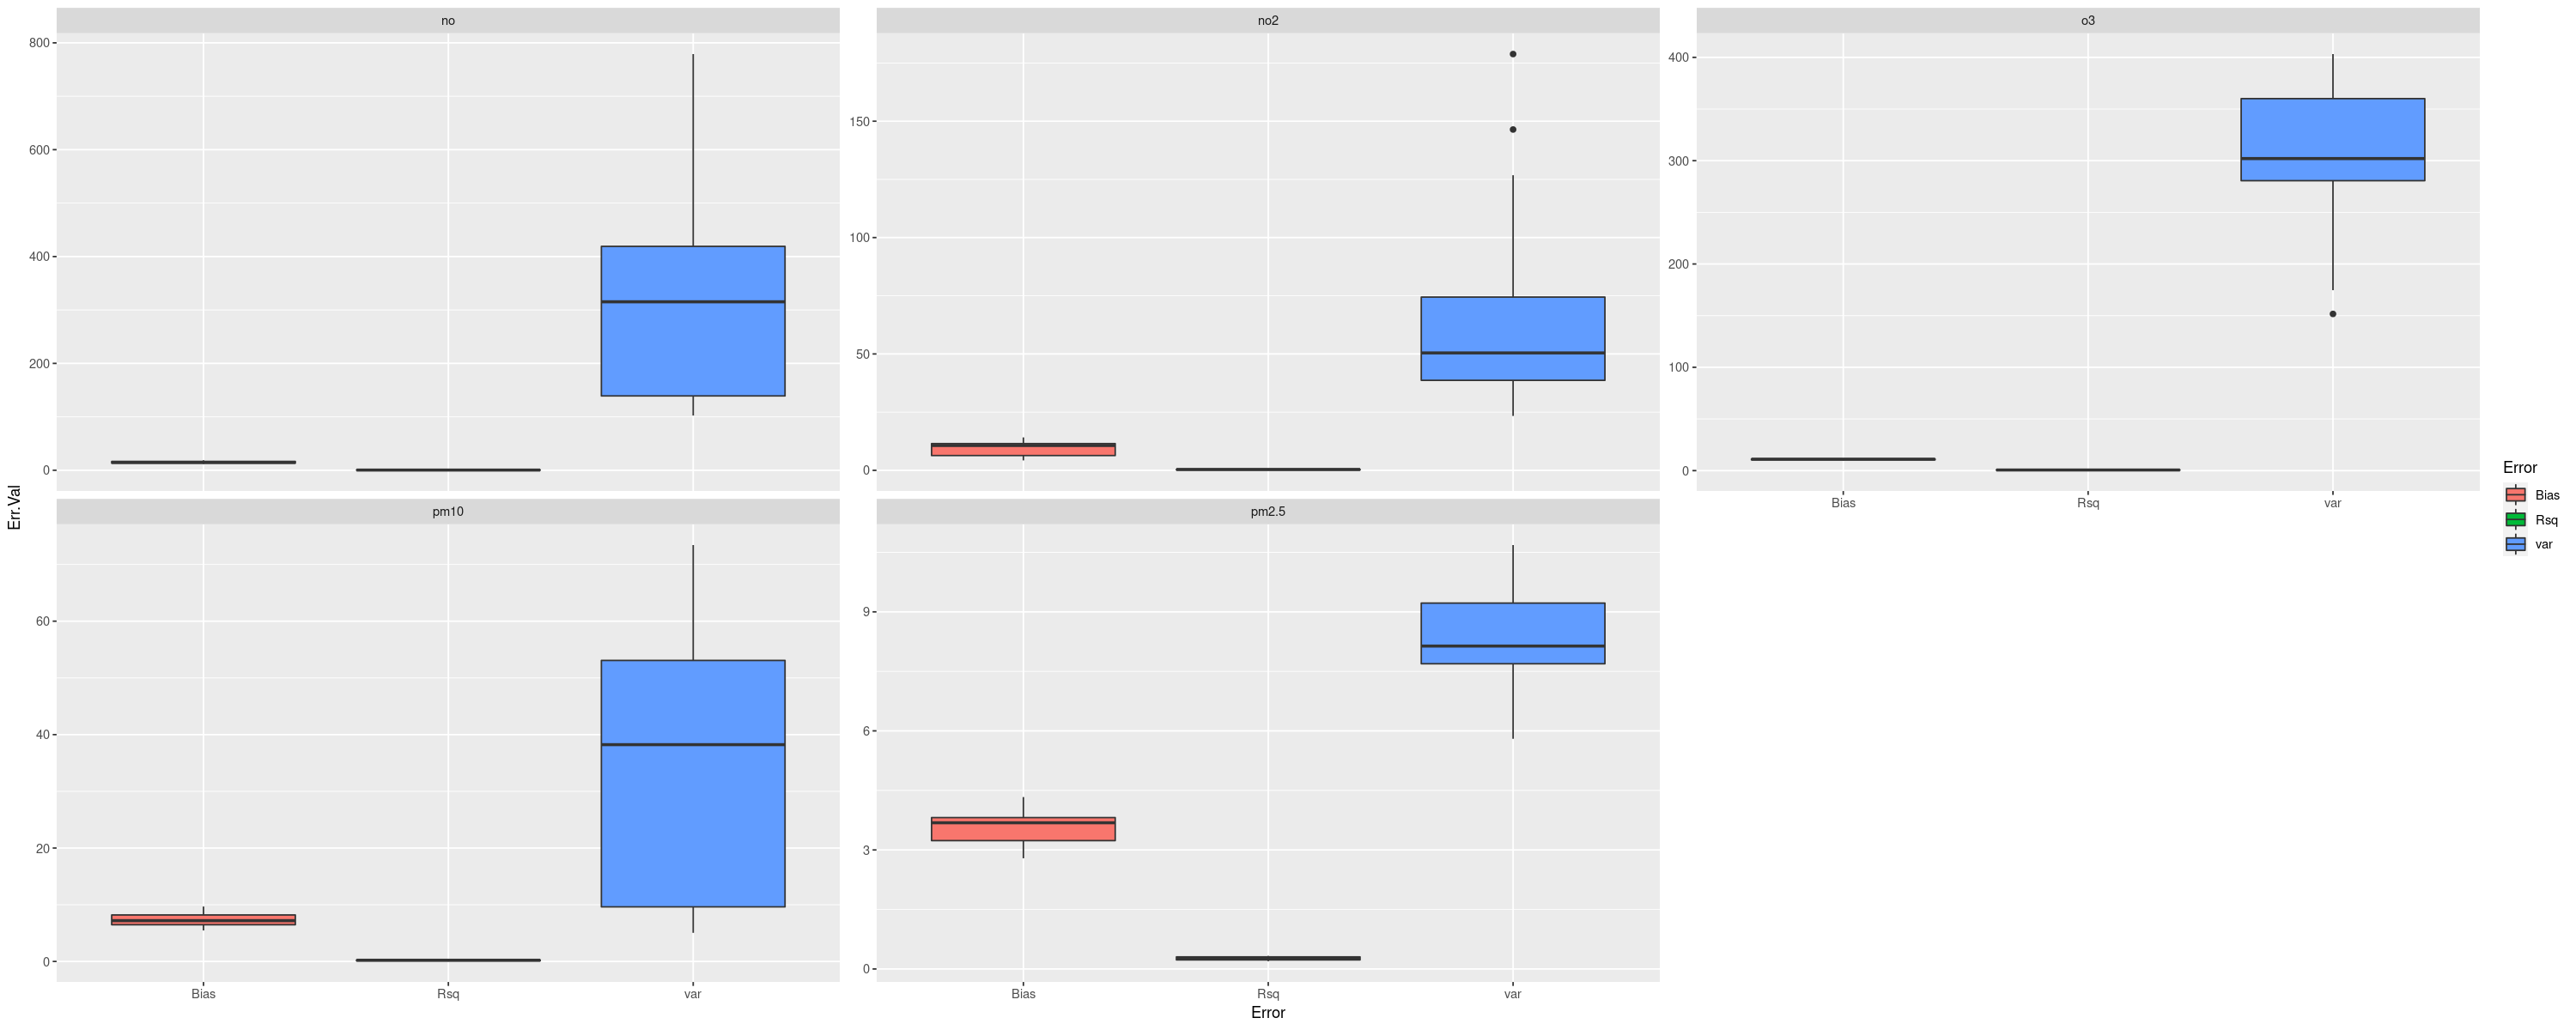

In [11]:
a <- cv.df %>%
        pivot_longer(cols = c(4:6), 
                     names_to = "Error", values_to = "Err.Val")

ggplot(data=a, aes(x=Error, y=Err.Val, fill=Error)) +
        geom_boxplot() + 
        facet_wrap(~variable, scales = "free_y")